<br><br>

# Uso de filtros espaciales y morfológicos

<br><br>

Actividad en equipo, conformado por:
- **Pelucio Manuel Vega Rodríguez**
- **Enrique Manuel Coloch Tahuico**
- **Aziel Eliú León Díaz**

(Equipo 21)

<br>

Requerimientos:
- Python >= 3.8
- Librerías:
    - numpy
    - matplotlib
    - opencv-python
    - scikit-image

<br>

### Imágenes a utilizar:

|      Cámara seguridad (tienda)      |     Vehículo Autónomo (carretera)     |
|:-----------------------------------:|:-------------------------------------:|
| <img src="data/t1.jpg" width='200'> | <img src="data/rimg1.jpg" width='200'> |


<br><br><br><br>

---

<br><br><br>

## Métodos

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def load_image(filename: str):
    """Lee una imagen de disco y la retorna en RGB y escala de grises.

    Parameters
    ----------
    filename : str
        Nombre del archivo a leer (se debe de incluir ruta).

    Returns
    -------
    tuple[np.ndarray, np.ndarray]
        Imagen RGB y en escala de grises

    """
    import cv2
    img = cv2.imread(filename)
    # convert to RGB
    rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # convertir a escala de grises
    grayscale = cv2.cvtColor(rgb, cv2.COLOR_BGR2GRAY)
    return rgb, grayscale


def show_image(img, title = None, gray: bool = True):
    """Grafica de manera muy simple una imagen.

    Parameters
    ----------
    img : np.ndarray
        Imagen a graficar.
    title : str
        Título de la gráfica (imagen)
    gray : bool
        Indica si se requiere graficar en escala de grises. Por defecto: True

    """
    import matplotlib.pyplot as plt
    plt.figure(figsize = (10, 6))
    if title:
        plt.title(f'{title} - {img.shape}')
    else:
        plt.title(f'Img size: {img.shape}')
    plt.imshow(img, cmap='gray') if gray else plt.imshow(img)

    
def binarize(img, threshold = int(255/2)):
    """Binariza una imagen en blanco y negro a partir de un threshold.

    Parameters
    ----------
    img : np.ndarray
        Imagen a binarizar.
    threshold : int
        Umbral de partición.

    """
    binarized = img.copy()
    binarized[binarized <= threshold] = 0
    binarized[binarized > threshold] = 255
    return binarized


def binarize_white(img, threshold = 127):
    """Binariza una imagen resaltando blancos.

    Parameters
    ----------
    img : np.ndarray
        Imagen a binarizar.
    threshold : int
        Umbral de partición.

    """
    return np.uint8((img < threshold)*255)


def label_objects(img, object_threshold = 100, original_img = np.zeros(1)):
    """Etiquetar objetos y etiquetarlos.
    Función obtenida de https://scikit-image.org/docs/dev/auto_examples/segmentation/plot_label.html

    Parameters
    ----------
    img : np.ndarray
        Imagen a detectar objetos.
    object_threshold : int
        Umbral de detección. Por defecto: 100
    original_img : np.ndarray
        Imagen original.

    """
    import matplotlib.pyplot as plt
    import matplotlib.patches as mpatches

    from skimage import data
    from skimage.filters import threshold_otsu
    from skimage.segmentation import clear_border
    from skimage.measure import label, regionprops
    from skimage.morphology import closing, square
    from skimage.color import label2rgb

    # apply threshold
    thresh = threshold_otsu(img)
    bw = closing(img > thresh, square(3))

    # remove artifacts connected to image border
    cleared = clear_border(bw)

    # label image regions
    label_image = label(cleared)
    # to make the background transparent, pass the value of `bg_label`,
    # and leave `bg_color` as `None` and `kind` as `overlay`
    image_label_overlay = label2rgb(label_image, image=img, bg_label=0)

    fig, ax = plt.subplots(figsize=(10, 6))
    
    # si se manda la imagen original, se añade esa, de lo contrario, solo la de procesamiento
    if original_img.any():
        ax.imshow(original_img)
    else:
        ax.imshow(image_label_overlay)
    
    object_counter = 0

    for region in regionprops(label_image):
        # take regions with large enough areas
        if region.area >= object_threshold:
            # draw rectangle around segmented coins
            minr, minc, maxr, maxc = region.bbox
            rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                      fill=False, edgecolor='red', linewidth=2)
            ax.add_patch(rect)
            object_counter += 1

    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    fig.suptitle(f'Total de personas: {object_counter}', fontsize=16)
    
    
def get_lines(img, eimg):
    """Traza líneas rectas en una imagen dada las lineas existentes en la imagen entrante.

    Parameters
    ----------
    img : np.ndarray
        Imagen a detectar líneas.
    eimg : np.ndarray
        Imagen con bordes
    
    """
    lines = cv2.HoughLinesP(eimg, 1, np.pi/180, 80, minLineLength=80, maxLineGap=10)
    for line in lines:
        x1, y1, x2, y2 = line[0]
        cv2.line(img, (x1,y1), (x2,y2), (255,0,0), 2, cv2.LINE_AA)
    return img 

<br><br><br>

---

<br><br>

# 1. Tienda

Lectura de imágenes:

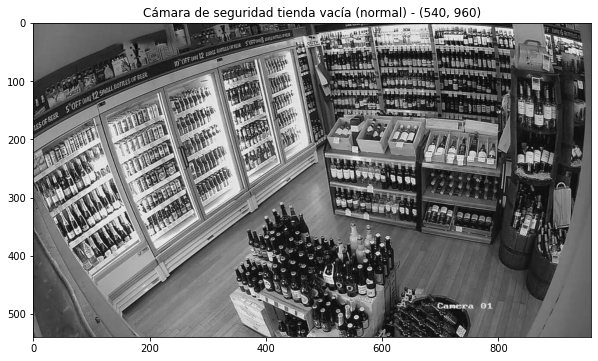

In [3]:
img_1, grayscale_1 = load_image('data/t1.jpg')

show_image(grayscale_1, title='Cámara de seguridad tienda vacía (normal)')

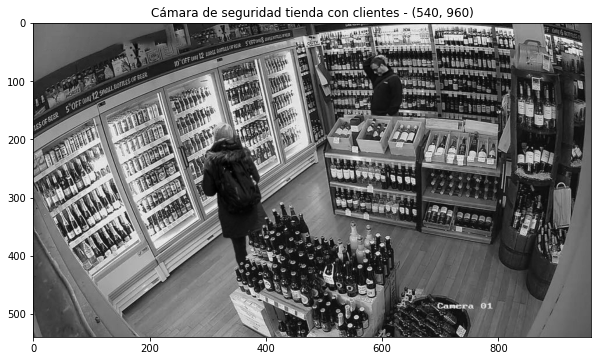

In [4]:
img_2, grayscale_2 = load_image('data/t2.jpg')

show_image(grayscale_2, title='Cámara de seguridad tienda con clientes')

<br>

### Operación aritmética resta para aislar a las personas
Esta operación resalta pixeles muy diferentes, permitiendo diferenciar objetos o personas que se encuentran en un estado, que no se encontraban en otro anterior.

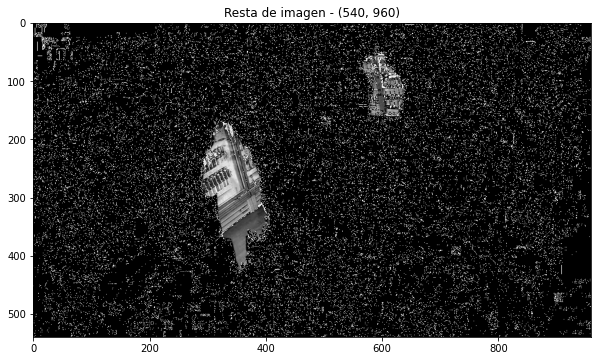

In [5]:
diff = grayscale_1-grayscale_2
show_image(diff, title='Resta de imagen')

<br>

### Remover ruido
Se aplica una apertura (erosión-dilatación) para remover ruido utilizando las funciones de OpenCV:
- ```cv2.erode```
- ```cv2.dilate```

Se probaron diferentes combinaciones de tamaño de kernel, así como elementos estructurales. <br>
Kernel tamaño 3 (k=3) y forma estructural "cuadrada", fue la más apropiada y con mejores resultados para nuestra imagen.

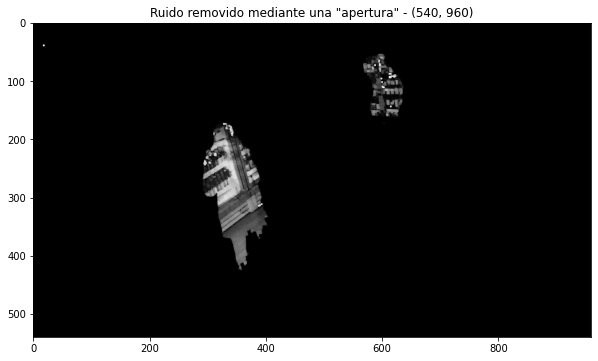

In [6]:
k_size = 3 # (3, 7, 9)
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (k_size, k_size))

cleaned = cv2.erode(diff, kernel, iterations=1)
cleaned = cv2.dilate(cleaned, kernel, iterations=1)

show_image(cleaned, title='Ruido removido mediante una "apertura"')

<br>

### Binarizar imagen
Binarizamos la imagen con un umbral bajo para aislar lo más posible los blancos. <br>
Un umbral bajo, permite resaltar más los pixeles blancos dentro de la imagen, mientras que un umbral alto, permite resaltar más los pixeles negros dentro de una imagen.

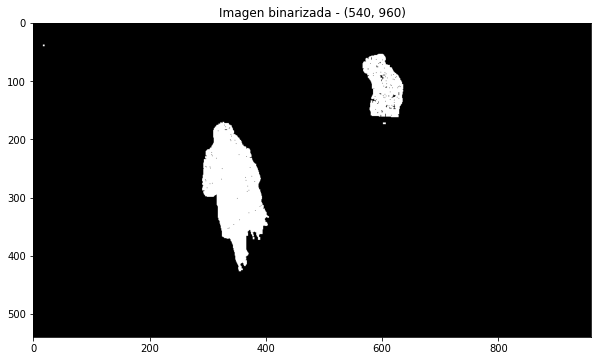

In [7]:
binarized = binarize(cleaned, threshold=2)
show_image(binarized, title='Imagen binarizada')

<br>

### Dilatar
Se observa que quedaron resuidos negros dentro de las siluetas de las personas. <br>
Aplicamos una dilatación para rellenarlos.

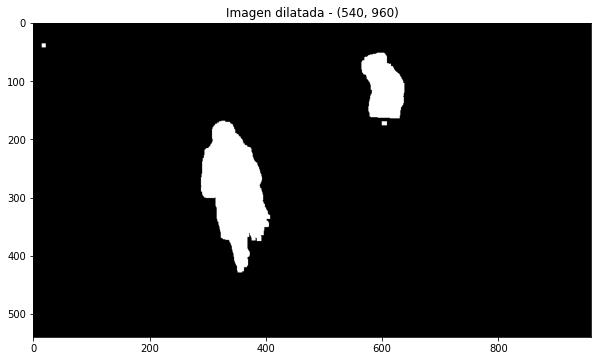

In [8]:
k_size = 3
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (k_size, k_size))

cleaned = cv2.dilate(binarized, kernel, iterations=2)
show_image(cleaned, title='Imagen dilatada')

<br>

### Filtro para detectar bordes
Vemos que el resultado anterior es suficientemente bueno, ya que las siluetas remarcan la figura de la persona. <br>
Sin embargo, se aplica un filtro de Canny utilizando la libreróa de OpenCV: ```cv2.Canny``` para señalar el contorno de las personas y ver si se puede apreciar de mejor manera sus movimientos. Esto sólo con fines de observación.

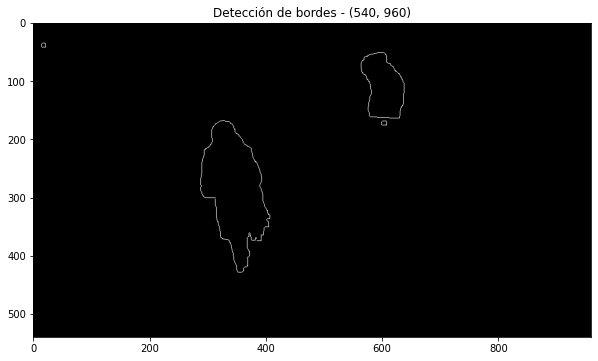

In [9]:
edges = cv2.Canny(cleaned, 200, 200)
show_image(edges, title='Detección de bordes')

<br>

### Detectar personas utilizando método de "Label image regions"
Finalmente mandamos llamar la función que permite etiquetar regiones en una imagen, y observamos que exitosamente se logran detectar las 2 personas que se encuetran en la imagen original.

Imagen original:

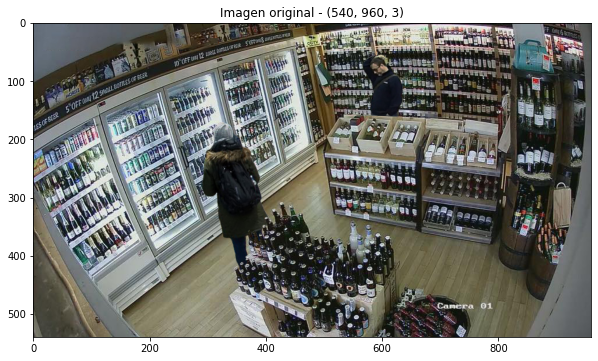

In [10]:
show_image(img_2, title='Imagen original')

<br>

Detección de personas en imagen procesada:

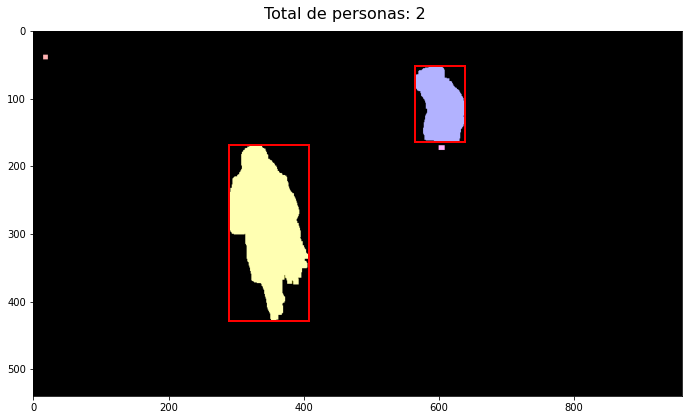

In [11]:
label_objects(cleaned)

<br>

Detección de personas (modo real productivo):

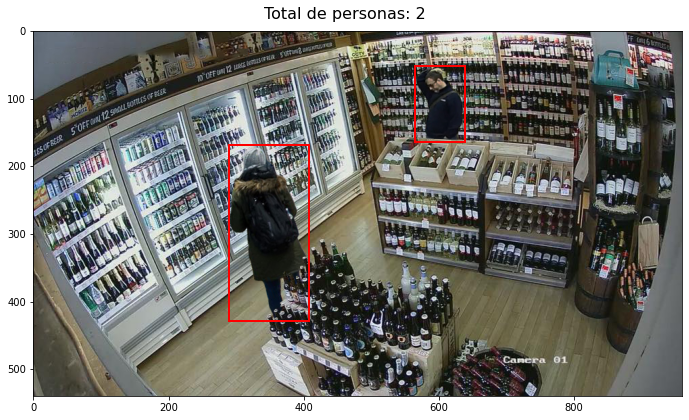

In [12]:
label_objects(cleaned, original_img=img_2)

<br><br><br>

---

<br><br>

# 2. Carretera

Se tienen 4 imágenes:
- rimg1
- rimg2
- rimg3
- rimg4

Todas tienen extensión _.jpg_ de tal manera que si queremos usar cualquiera de ellas solo cambiaremos el número en la siguiente línea de codigo: <br>
```rimg = cv2.imread('rimg1.jpg')```

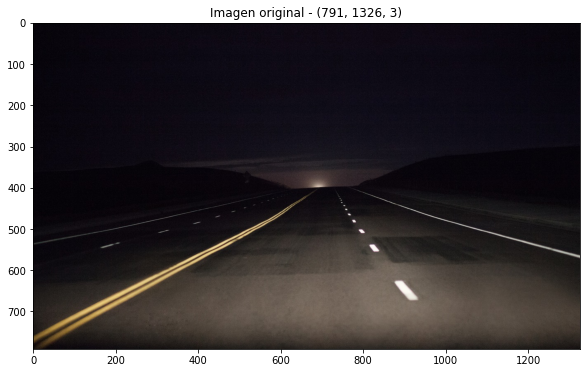

In [13]:
rimg, rimg_gray = load_image('data/rimg1.jpg')

show_image(rimg, title='Imagen original')

<br>

### Suavizado de imagen
Aplicaremos el suavizado Gaussiano para desenfocar un poco la imagen con el objetivo de eliminar algún ruido y mejorar el efecto a escala de grises con la función de OpenCV: ```cv2.GaussianBlur```

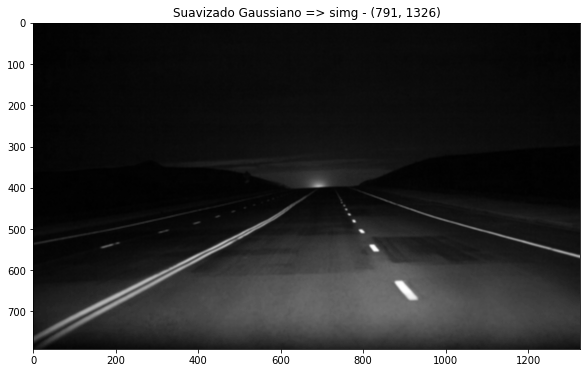

In [14]:
# para rimg4, k_size = 9 es el óptimo y
# k_size = 5 para los demás 
k_size = 5

simg = cv2.GaussianBlur(rimg_gray, (k_size, k_size), cv2.BORDER_DEFAULT)

show_image(simg, title='Suavizado Gaussiano => simg')

<br>

### Detección de bordes y binarización
Una vez suavizada nuestra imagen, procedemos a detectar los bordes de las líneas a través de la función de OpenCV ```cv2.Canny(img, lts, hts)```, donde:
- _lts_ es el umbral minimo y
- _hts_ es el umbral maximo.

Dado que las líneas separadoras de carriles y las bermas siempre son de color blanco o amarillo (colores claros) binarizaremos la imagen teniendo esta consideracion en la función ```binarize_white(img, threshold)```.

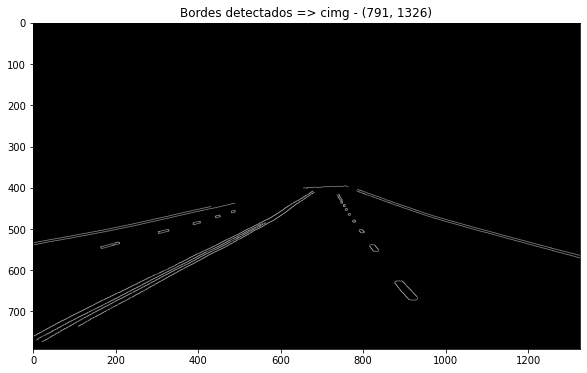

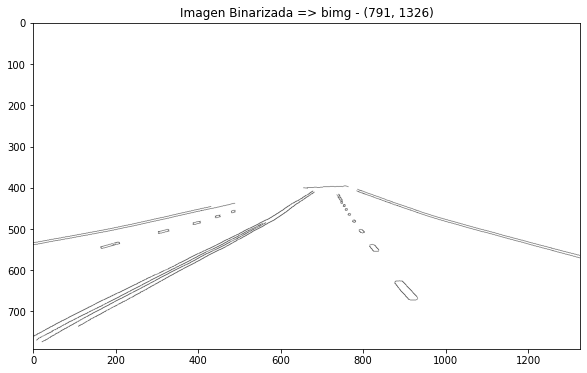

In [15]:
cimg = cv2.Canny(simg, 50, 130)
show_image(cimg, title='Bordes detectados => cimg')

bimg = binarize_white(cimg)
show_image(bimg, title='Imagen Binarizada => bimg')

<br>

### Aplicación de Operaciones Morfológicas
A nuestra imagen binarizada le aplicamos la operación morfológica de **apertura** a través de la función: <br> ```cv2.morphologyEx(bimg, cv.MORPH_OPEN, kernel)``` de OpenCV con la finalidad de eliminar y/o disminuir el ruido y suavizar sus  límites.


Posteriormente a la imagen resultante de la operación de apertura le aplicaremos la operación morfológica de **Cierre**: <br>
```cv2.morphologyEx(bimg, cv.MORPH_CLOSE, kernel)``` de OpenCV con la finalidad de simplificar las lineas detectadas.

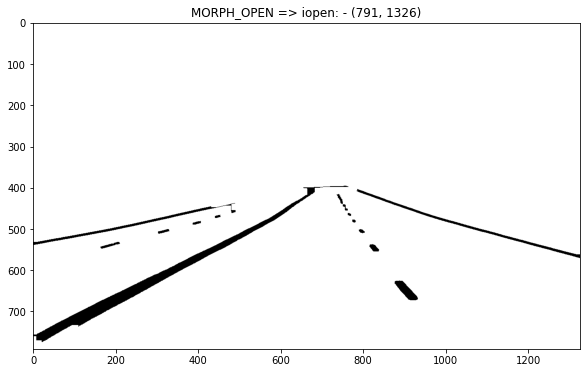

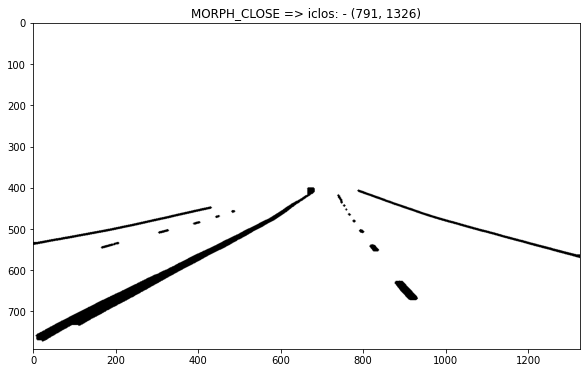

In [16]:
#_RECT, _CROSS O _ELLIPSE
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (15, 15))
iopen = cv2.morphologyEx(bimg, cv2.MORPH_OPEN, kernel) 
show_image(iopen, title='MORPH_OPEN => iopen:')


kernel = cv2.getStructuringElement(cv2.MORPH_CROSS, (5, 5))
iclos = cv2.morphologyEx(iopen, cv2.MORPH_CLOSE, kernel)
show_image(iclos, title='MORPH_CLOSE => iclos:')

<br>

### Detectamos los bordes de las lineas de carriles y los resaltamos
Una vez simplificada nuestra imagen pasamos a detectar los bordes a través de la función: <br>
```cv2.Laplacian(iclos, cv.CV_64F)``` de OpenCV para posteriormente resaltar los carriles detectados mediante trazos de rectas color rojo. 

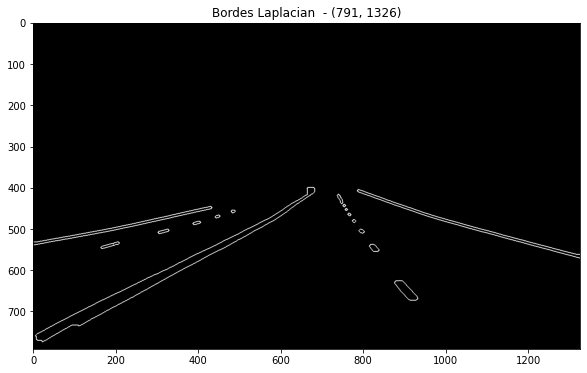

In [17]:
limg = cv2.Laplacian(iclos, cv2.CV_64F) 
limg = cv2.convertScaleAbs(limg)
show_image(limg, title='Bordes Laplacian ')

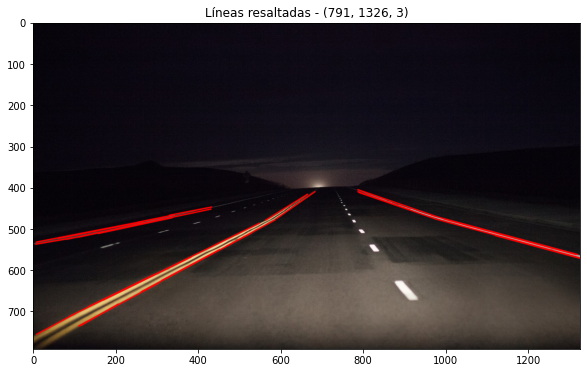

In [18]:
get_lines(rimg, limg)
show_image(rimg, title='Líneas resaltadas')

<br><br><br><br><br>

### Referencias

<br>

- Para convertir de un espacio de color a otro: <br>
  https://www.geeksforgeeks.org/python-opencv-cv2-cvtcolor-method/

  
- Referencia API para graficar imágenes con Matplotlib: <br>
  https://matplotlib.org/stable/api/index.html
  
  
- Etiquetar objetos en imagen: <br>
  https://scikit-image.org/docs/dev/auto_examples/segmentation/plot_label.html
  

- Convertir a blanco y negro: <br>
  https://techtutorialsx.com/2018/06/02/python-opencv-converting-an-image-to-gray-scale/
  

- Operaciones morfológicas: <br>
  https://docs.opencv.org/3.4/d4/d76/tutorial_js_morphological_ops.html


- Laplaciano (filtro espacial de realce): <br>
  https://docs.opencv.org/3.4/d5/db5/tutorial_laplace_operator.html


- Cany (detección de contornos o bordes): <br>
  https://docs.opencv.org/4.x/da/d22/tutorial_py_canny.html


- Filtrado de imágenes: <br>
  https://docs.opencv.org/3.4/d4/d86/group__imgproc__filter.html
  

- Suavizado Gaussiano: <br>
  https://docs.opencv.org/4.x/d4/d13/tutorial_py_filtering.html
  

- Detección de líneas y círculos <br>
  http://acodigo.blogspot.com/2017/09/deteccion-de-lineas-y-circulos-usando.html


<br><br>

<br><br><br><br><br>